# Unsupervised Learning 
## Content-based recommendation system
## Semantic representation of data using SOM


### Basic Libraries

In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install --upgrade somoclu

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
import pandas as pd


dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [ ]:
print(df_data_1.shape)
print("First movie:")
print(df_data_1.iloc[0,:])

(22302, 6)
First movie:
0                                               975900
1                                                    1
2                                       Ghosts of Mars
3    "Thriller",  "Science Fiction",  "Horror",  "A...
4    0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...
5    Set in the second half of the 22nd century, th...
Name: 0, dtype: object


Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα έχει έναν αριθμό "seed" (φύτρο) που είναι ο ίδιος με τον αριθμό της ομάδας σας: θα τον βρείτε στην κολόνα Α/Α [εδώ](https://docs.google.com/spreadsheets/d/1CD6AtX7YnocXceCELl_XJ06kyRr0YQPhor8dpw012t0/edit?usp=sharing).

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
import numpy as np

# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 32

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1EA_pUIgK5Ub3kEzFbFl8wSRqAV6feHqD"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

In [ ]:
print(titles.shape)
print(categories.shape)
print(bins.shape)
print(catbins.shape)
print(summaries.shape)
print(len(corpus))

(5000, 1)
(5000, 1)
(22302, 1)
(5000, 322)
(5000, 1)
5000


- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [ ]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Swarmed']
['"Thriller",  "Natural horror films",  "Horror",  "Television movie",  "Action/Adventure",  "Action"']
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus).toarray()

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης. Ανατρέξτε στα notebooks του εργαστηρίου και στο [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing) των ασκήσεων.


In [ ]:
print(corpus_tf_idf.shape)
print(vectorizer.vocabulary_)

(5000, 47989)
{'set': 38110, 'in': 20783, '1986': 315, 'the': 42749, 'film': 15630, 'tells': 42498, 'story': 40931, 'of': 29954, 'one': 30107, 'gory': 17813, 'day': 10785, 'october': 29923, '15th': 109, 'woodmire': 47120, 'lake': 23961, 'small': 39489, 'town': 43514, 'midwest': 27333, 'as': 2952, 'recounted': 34849, 'by': 6476, 'detective': 11578, 'tim': 43096, 'malley': 25926, 'through': 42957, 'voice': 45998, 'over': 30571, 'course': 9836, 'this': 42871, 'all': 1809, 'but': 6430, 'member': 27022, 'kent': 23144, 'and': 2202, 'todd': 43254, 'families': 15117, 'are': 2745, 'brutally': 6132, 'killed': 23311, 'dismembered': 12226, 'gopikrishna': 17785, 'owns': 30724, 'an': 2141, 'old': 30035, 'bus': 6395, 'received': 34733, 'compensation': 8913, 'for': 16204, 'his': 19609, 'father': 15254, 'road': 36167, 'accident': 978, 'he': 19094, 'is': 21795, 'facing': 15009, 'lots': 25214, 'consequences': 9269, 'due': 13036, 'to': 43232, 'pathetic': 31288, 'condition': 9082, 'sold': 39781, 'many': 26

#### Εισαγωγή βιβλιοθηκών
Εισάγουμε όσες επιπλέον βιβλιοθήκες χρειάζονται

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

''' Βοηθητική συνάρτηση GetCosSim() όπου μας επιστρέφει τη λίστα της ομοιότητας συνημιτόνου '''
def GetCosSim(TargetMovie, corpus_tf_idf):
  cosine_sim_list = [] #ορίζουμε τη λίστα
  for i in range(len(corpus_tf_idf)):
      cosine_sim_list.append( float(cosine_similarity([corpus_tf_idf[TargetMovie]], [corpus_tf_idf[i]])) )
  return cosine_sim_list

''' Συνάρτηση content_recommender όπου μας επιστρέφει τις συστάσεις και την ταξινομημένη λίστα ομοιότητας συνημιτόνου  '''
def content_recommender(target_movie, max_recommendations):
    
    cosine_sim_list = GetCosSim(target_movie, corpus_tf_idf)
    cosine_sim_sorted = sorted(cosine_sim_list)
    cosine_sim_argmax = np.argsort(cosine_sim_list)[::-1]    

    recommendations = cosine_sim_argmax[1:max_recommendations+1] # αγνόησε το πρώτο στοιχείο γιατί μετράει τη διαφορά με τομν εαυτό του

    return recommendations, cosine_sim_sorted

In [ ]:
# Χρήση παραδείγματος
target_movie = 2999
max_recommendations = 5
print("Target movie info:\n", "ID:", target_movie, "\n", "Title:", titles[target_movie],
      "\n", "Plot:", corpus[target_movie], "\n", "Categories:", categories[target_movie])
print()

recommendations,_ = content_recommender(target_movie, max_recommendations)

print("-------------------------------")
print("***" + " " + "Recommendations" + " " + "***")
print("-------------------------------")
print()
for i,rec_movie in enumerate(recommendations):
    print("\033[1m" + "***" + " " + "Recommended movie No. " + str(i+1) + " " + "***" + "\033[0m")
    print("Id:", rec_movie)
    print("Title:", titles[rec_movie])
    print("Plot:", corpus[rec_movie])
    print("Categories:", categories[rec_movie])
    print()

Target movie info:
 ID: 2999 
 Title: ['Firehouse'] 
 Plot: An evil businessman is secretly setting fires to some of the old buildings of a dilapidated neighborhood, while at the same time three women become the new recruits at a local fire station. Life is not smooth at the new firehouse, as the women are teased and harassed by their male coworkers. But they learn to stand up for themselves against the torment while also solving the mystery of who is starting the fires. 
 Categories: ['"Comedy film"']

-------------------------------
*** Recommendations ***
-------------------------------

*** Recommended movie No. 1 ***
Id: 22
Title: ['Banned From Television']
Plot:  The film opens with a montage of some of the clips that are used throughout the film. After this the film begins. In Rio de Janeiro, Brazil, a man with a knife holds an innocent baby as hostage. Police surround him and when he gets distracted an officer shoots him in the head, killing him instantly. The baby is taken awa

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1hou1gWXQuHAB7J2aV44xm_CtAWJ63q6Cu1V6OwyL_n0/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




#### Τεχνική βελτιστοποίησης

Για τη βελτίωση του συστήματος που φτιάχνουμε, είναι σημαντικό να αφαιρεθεί ένας σημαντικός όγκος δεδομένων λέξεων, ο οποίος αποτελεί θόρυβο στις αποτελεσματικότητα των συστάσεων. Γι'αυτό συλλέγουμε όλες εκείνες τις λέξεις που γνωρίζουμε ότι εμφανίζονται συχνά αλλά δεν βοηθούν το σύστημα και τις αποθηκεύουμε σε μία λίστα. 

Καταρχάς δημιουργούμε μία λίστα με τις συχνά χρησιμοποιούμενες λέξεις στη περιγραφή ταινιών (π.χ. movie, film, ...). Στη συνέχεια θέλουμε να ομαδοποιήσουμε τα ονόματα που παρουσιάζονται στις περιγραφές. Γι' αυτό χρησιμοποιούμε μία έτοιμη βιβλιοθήκη της python και δημιουργούμε τρία αρχεία με αντρικά και γυναικεία ονόματα, καθώς και επώνυμα. Τέλος κατεβάζουμε τις συχνά χρησιμοποιούμενες αγγλικές stopwords.

Όλα τα παραπάνω τα αθροίζουμε σε μίοα λίστα με όνομα stop_words και τα αφαιρούμε από τις περιγραφές.

#### Διάβασμα αρχείων
Η συνάρτηση ```OpenFile```  διαβάζει ένα csv αρχείο και διαγράφει τις περιττές στήλες, κάτι που χρειαζόμαστε για τη συνέχεια.

In [ ]:
def OpenFile(filename):
  # διάβασε το csv αρχείο 
  df = pd.read_csv(filename, header = None) 
  # διέγραψε τις στήλες που δεν χρειαζόμαστε
  del df[1]
  del df[2]
  del df[3]
  # μετατροοπή από κεφαλαία σε πεζά
  df = df[0].str.lower()
  # επέστραψε το dataframe ως λίστα
  return list(df) 





#### Stopwords - αφαίρεση ονομάτων
Από μία έτοιμη βιβλιοθήκη [names](https://pypi.org/project/names/#modal-close)  της  ```pyhton``` , εξάγαμε τα [αρχεία ονομάτων](https://drive.google.com/drive/folders/1_-djwmvDYQ7WSCNBxP4RHS5o_2s9Pegr?usp=sharing) males.csv, females.csv και lastnames.csv . Παράλληλα με τα ```stopwords``` θέλουμε να αφαιρέσουμε από το corpus τις συχνά χρησιμοποιούμενες λέξεις. Τελικά αθροίζουμε και αφαιρούμε τα συχνά ονόματα, τις συχνές αγγλικές λέξεις και κάποιες λέξεις που διαπιστώσαμε ότι εμαφανίζονται συχνά στα corpus και διαστρεβλώνουν το σύστημα μας. 

In [ ]:
from sklearn.feature_extraction import text
import nltk
nltk.download('stopwords')

# συχνές λέξεις που δεν χρειαζόμαστε
words_in_movies = ["movie", "film", "plot", "story", "cinema", "opens", "about"]

# φόρτωσε τις συχνές αγγλικές λέξεις και προόσθεσαι και τις παραπάνω
stop_words = text.ENGLISH_STOP_WORDS.union(["book"]) 
stop_words = set(stop_words) 
stop_words = list(stop_words)
stop_words = stop_words + words_in_movies

# open τα αρχεία ονομάτων
males = OpenFile("males.csv")
females = OpenFile("females.csv")
lastnames = OpenFile("lastnames.csv")

# τα ομαδοποιώ όλα στο stop_words
stop_words = stop_words + males +females + lastnames

nltk.download('punkt') # χρειάζεται για το tokenizer
words = []
for doc in corpus:
    words += nltk.word_tokenize(doc)
print("Total words in corpus:\t", len(words))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total words in corpus:	 1727877


In [ ]:
!ls 

females.csv  lastnames.csv  males.csv  preprocessed_corpus.pkl	sample_data


#### Πρόσθετη βελτιστοποίηση - Stemmer & Lemmatization

* Με τη συνάρτηση ```thorough_filter``` αφαιρούμε όλα τα σημεία στήξις από τις περιγραφές. 
* Κάνουμε stemming και lemmatizing, για να κόψουμε τις καταλήξεις και να ομαδοποιήσουμε τις λέξεις με ίδια ρίζα. Αυτά υλοποιούνται στη συνάρτηση ```preprocess_document```.



In [ ]:
import collections
import string
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')

def thorough_filter(words):
    # Filter some more punctuations
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words


def preprocess_document(document, stemming=True):
    # if stemming = false then lemmatizing

    # convertion to lowercase
    words = nltk.word_tokenize(document.lower())

    # punctuation
    filtered_words = [word for word in words if word not in (stop_words) + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)

    # Εφαρμογή stemming/lemmatizing
    if stemming:
        words = [PorterStemmer().stem(word) for word in filtered_words]
    else:
        words = [WordNetLemmatizer().lemmatize(word) for word in filtered_words]

    return " ".join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Store variables

In [ ]:
'''ATTENTION : Δεν ξανατρέχω αυτό το cell ξανά'''
# Preprocessing corpus   
%time preprocessed_corpus = [preprocess_document(doc) for doc in corpus]

CPU times: user 22min 3s, sys: 9.72 s, total: 22min 13s
Wall time: 22min 14s


In [ ]:
import joblib
joblib.dump(preprocessed_corpus, 'preprocessed_corpus.pkl') 

['preprocessed_corpus.pkl']

In [ ]:
import joblib
preprocessed_corpus = joblib.load('preprocessed_corpus.pkl') # load

In [ ]:
print(preprocessed_corpus[1])

gopikrishna own bu receiv compens father 's road accid face lot consequ pathet condit bu sold valuabl thing maintain bu azhagu cleaner bu mous eaten passport azhagu spoil chanc abroad 's comedi involv azhagu mous reveng live tv gopikrishna insult traffic commission troubl command gopikrishna leav bu advoc tri help run mobil bu took turn girl name basanthi enter bu nomad actual gayathri daughter influenti polit power minist pondicherri father forc join polit leav home initi girl refus leav bu despit effort unni sundaresan father 's custodi father make arrang marriag gopikrishna realis live gayathri gopi azhagu secretli enter final end win father


### Δημιουργία corpus_tf_idf

Εδώ καλούμε τη συνάρτηση TfidfVectorizer, η οποία έχει παραμέτρους για βελτιστοποίηση. Καταλυκτικά οι παράμετροι που επηρεάζουν περισσότερο τα αποτέλεσματα είναι οι stopwords, max_df και min_df. Για την stop_words δεν κάναμε κάτι περισσότερα από τα παραπάνω. Όσον αφορά τις max_df, min_df:
* H max_df μετά από δοκιμές φάνηκε να μην επηρεάζει ιδιαίτερα τα αποτελέσματα, κάτι που ενδεχομένως να συμβαίνει επειδή ήδη έχουμε αφαιρέσει με την stop_words λέξεις που εμφανίζονται συχνά. Γι' αυτό βάζουμε τη τιμή 0.5, ώστε να "κόβει" τις λέξεις από τις μισές περιγραφές.
* Η min_df φάνηκε να επηρεάζει περισσότερο το σύστημα και γι' αυτό κάναμε περισσότερες δοκιμές. Εδώ η τιμή που δουλεύουμε αναφέρεται σε πλήθος λέξεων. Εξετάσαμε ενα φάσμα τιμών μεταξύ των 10-20, καθώς από 10 και κάτω δεν έκοβε αρκετές λέξεις, ενώ από 20 και πάνω περισσότερες από όσες θα θέλαμε. Γι΄αυτό καταλήγουμε στο 15, που φαίνεται να αποδίδει καλύτερα.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, min_df=15, stop_words=stop_words)
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf = vectorizer.transform(preprocessed_corpus).toarray()
print(corpus_tf_idf.shape) 

(5000, 3118)


Έχοντας τελειώσει με την προεπεξεργασία δεδομένων, φτιάχνουμε τη συνάρτηση ```show_recommandations()```, όπου παίρνοντας ως παράμετρο το ```id``` της ταινίας μας εκτυπώνει 10 προτινόμενες ταινίες σύμφωνα με το σύστημά μας.

In [ ]:
def show_recommendations(target_movie):
    
    max_recommendations = 10
    print("Target movie info:\n", "ID:", target_movie, "\n", "Title:", titles[target_movie],
        "\n", "Plot:", corpus[target_movie], "\n", "Categories:", categories[target_movie], "\n",
        preprocessed_corpus[target_movie])
    print()

    recommendations, sort_cos = content_recommender(target_movie, max_recommendations)

    print("-------------------------------")
    print("***" + " " + "Recommendations" + " " + "***")
    print("-------------------------------")
    print()
    for i,rec_movie in enumerate(recommendations):
        print("\033[1m" + "***" + " " + "Recommended movie No. " + str(i+1) + " " + "***" + "\033[0m")
        print("ID:", rec_movie)
        print("Title:", titles[rec_movie])
        print("Plot:", corpus[rec_movie])
        print("Categories:", categories[rec_movie])
        print("processed corpus:", preprocessed_corpus[rec_movie])
        print()

    
    print(pd.DataFrame(sort_cos[::-1]).iloc[:11])

## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Σε markdown περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Επίσης σε markdown δώστε 10 παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε συνοπτικά ποια είναι η θεματική που ενώνει τις ταινίες.

Δείτε [εδώ](https://pastebin.com/raw/ZEvg5t3z) ένα παράδειγμα εξόδου του βελτιστοποιημένου συστήματος συστάσεων για την ταίνία ["Q Planes"](https://en.wikipedia.org/wiki/Q_Planes) με την κλήση της συνάρτησης για κάποιο seed `content_recommender(529,3)`. Είναι φανερό ότι η κοινή θεματική των ταινιών είναι τα αεροπλάνα, οι πτήσεις, οι πιλότοι, ο πόλεμος.

### Παραδείγματα στο recomadation sytem

Τρέχουμε 10 παραδειγματα, όπου διαπιστώνουμε το σύστημα μας να έχει ικανοποιητική απόδοση.

#### 1η - σχόλια 
* Ταινία: *The Inspector Wears Skirts*
* Κατηγορίες: Comedy film

Παρατηρούμε ότι έχει ακριβώς ίδια κατηγορία με την 3, ενώ κινείται στις ίδιες θεματικές με τις 4,5,6. 

In [ ]:
show_recommendations(2999)

Target movie info:
 ID: 2999 
 Title: ['Firehouse'] 
 Plot: An evil businessman is secretly setting fires to some of the old buildings of a dilapidated neighborhood, while at the same time three women become the new recruits at a local fire station. Life is not smooth at the new firehouse, as the women are teased and harassed by their male coworkers. But they learn to stand up for themselves against the torment while also solving the mystery of who is starting the fires. 
 Categories: ['"Comedy film"'] 
 evil businessman secretli fire build dilapid neighborhood time women recruit local station smooth firehous women teas harass male cowork stand torment solv mysteri start fire

-------------------------------
*** Recommendations ***
-------------------------------

*** Recommended movie No. 1 ***
ID: 4214
Title: ['Alaiyadikkuthu']
Plot: Brinda  is an employee of a medical company. She is not ready to be treated as a door matter and she is against women exploitation and atrocities brough

#### 2η - Σχόλια

* Ταινία: *Lady in the Dark*.
* Κατηγορίες: Drama, Black comedy, Comedy

Έχει ίδιες κατηγορίες όπως Drama, Comedy-Drama ή "κοντινές" κατηγορίες με τις προτεινόμενες 3,4,5,6,7,8,9,10. Βλέπουμε δηλαδή πως οι περισσότερες αντιστοιχούν στην ίδια κατηγορία αλλά γίνονται και συνδυασμοί όπου για παράδειγμα εδώ προτείνεται η κατηγορία Drama-Comedy στις ξεχωριστές Drama και Comedy. 

In [ ]:
show_recommendations(1999)

Target movie info:
 ID: 1999 
 Title: ['Angst'] 
 Plot: Angst tells the story of a group of horror film devotees living in Sydney's King's Cross. There's Dean ([[Sam Lewis , a cynical, sexually frustrated video store employee with a bad case of unresolved love. Then there are his flatmates Ian ([[Justin Smith  and Jade  - Ian works in an adult bookstore, waiting for his break as a stand-up comedian, whereas Jade doesn't work at all, content to smoke pot and watch videos while she can still get away with it. Wandering into our characters' lives is street kid Mole , who challenges Jade's lifestyle by stealing the trio's trusty VCR, and the alluring May , a goth chick on whom Dean develops an over-the-counter crush. It has been described as an Australian version of Kevin Smith's Clerks and Mallrats with the same Dark humor as SubUrbia. 
 Categories: ['"Black comedy",  "Drama",  "Comedy"'] 
 tell group horror devote live 's 's 's cynic sexual frustrat video store employe unresolv flatmat a

#### 3η - σχόλια 
* Ταινία: Uncle Nino
* Κατηγορία: Drama, Family Film, Family Drama, Comedy-drama, Comedy

Βλέπουμε ότι έχει τουλάχιστον μία κοινή κατηγορία με τις 2,4,5,6,7,8, ενώ οι θεματικές είνια πολύ κοντά. Έτσι θεωρούμε ότι το σύστημα μας αποδίδει.




In [ ]:
show_recommendations(19)

Target movie info:
 ID: 19 
 Title: ['Uncle Nino'] 
 Plot: The father, Robert Micelli , of the family, has become a stranger and thinks only of his lawn and job. After decades of no contact, Robert's Uncle Nino flies to America for an unexpected visit, with a suitcase full of home-made Italian wine.Nino helps the family realize the true value of family. 
 Categories: ['"Drama",  "Family Film",  "Family Drama",  "Comedy-drama",  "Comedy"'] 
 father micelli famili stranger think decad contact 's uncl unexpect visit suitcas home-mad italian wine.nino help famili realiz valu famili

-------------------------------
*** Recommendations ***
-------------------------------

*** Recommended movie No. 1 ***
ID: 4738
Title: ['Wolfman']
Plot: Colin Glasgow returning home after the murder of his uncle finds out that his uncle's will has been altered and his family is under a werewolf curse.Lots of twist and turns lead to Colin finding his old love Lynn and meeting a Priest that is more than meets t

#### 4η - σχόλια 
* Ταινία: Executive Suite
* Κατηγορία: Drama, Film adaptation

Εδώ βλέπουμε να έχει τουλάχιστον μία ίδια κατηγοράι με τις 2,3,6,7,9. Παράλληλα οι θεματικές είναι όμοιες με όλες τις συστάσεις, κατί που αποδεικνύει την ορθότητα του συστήματος. Παρατηρούμε δηλαδή ότι δεν αρκεί η κατηγορία για τη σύσταση, αλλά έχει σημαντικό ρόλο και ο περιοριστμός των λέξεων που εφαρμόσαμε.

In [ ]:
show_recommendations(12)

Target movie info:
 ID: 12 
 Title: ['Executive Suite'] 
 Plot: Avery Bullard, president and driving force of the Tredway Corporation, a major company in the small town of Millburgh, Pennsylvania, dies suddenly while in New York City. Bullard drops dead in the street after a stroke moments after telegraphing his secretary with orders to call a meeting of the executive board. At that meeting it was likely he would name an executive vice president who would be his presumptive successor. But Bullard is now dead and without an agreed successor. So the board of directors, four of whose members are vice presidents who could rise to the top job, must vote for his replacement. The frontrunner is the ambitious but unimaginative Loren Shaw, the company Controller concerned more with profitability and satisfying the stockholders than the quality of the company's products. He holds the proxy of the main shareholder and board member Julia Tredway, who had been hopelessly in love with Bullard. In ad

#### 5η - σχόλια 
* Ταινία: Should a Woman Divorce?
* Κατηγορία: Silent film, Drama

Εδώ παρατηρούμε ότι προκύπτει ίδια κατηγορία για τις ταινίες 1,2,3,5, ενώ οι θεματικές των ταινιών είναι αντίστοιχες.

In [ ]:
show_recommendations(82)

Target movie info:
 ID: 82 
 Title: ['Should a Woman Divorce?'] 
 Plot: Grace Roberts , marries rancher Edward Smith, who is revealed to be a crappy vice-ridden spouse. They have a daughter, Vivian. Dr. Franklin  whisks Grace away from this unhappy life, and they move to New York under aliases, pretending to be married . Grace and Franklin have a son, Walter . Vivian gets sick, however, and Grace and Franklin return to save her. Somehow this reunion, as Smith had assumed Grace to be dead, causes the death of Franklin. This plot device frees Grace to return to her father's farm with both children.<ref nameK7tPAAAAYAAJ&q%22Leonid+Samoloff%22&hlUFieTq3zIKbg0QHwytWmCQ&sabook_result&ct4&ved=0CDsQ6AEwAw The silents: silent feature films, 1910-36, Volume 40, Issue 2], p. 253 
 Categories: ['"Silent film",  "Drama"'] 
 marri rancher reveal crappi vice-ridden spous daughter dr. whisk away unhappi alias pretend marri get return reunion assum dead caus death devic return father 's farm children. 

#### 6η - σχόλια 
* Ταινία: Shaolin Temple
* Κατηγορία: Martial Arts Film, Chinese Movies

Εδώ βλέπουμε ότι εκτός από τη ταινία 5, όλες οι υπόλοιπες έχουν όμοια θεματική ενώ με την 9 ακριβώς ίδια. Παράλληλα παρατηρούμε ότι το cosine similarity είναι πολύ υψηλό για όλες τις ταινίες.

In [ ]:
show_recommendations(4)

Target movie info:
 ID: 4 
 Title: ['Shaolin Temple'] 
 Plot: The film opens with the chief Shaolin Monks realizing that time is not on their side and they must train more fighters to fight the Qings. The monk Hai Hsien  opposes this as he is secretly working for the court. Outside many men are sitting in front of the temple waiting to be accepted in, Fang Shih Yu , Ma Chao-hsing  and others, as the temple tests the will of potential students by making them wait outside for days, eventually the two are accepted in for “training”. Fang Shih Yu becomes frustrated immediately as Shaolin methods of teaching martial arts are rather obscure, although Ma Chao-hsing begins learning the five animal styles from the start. Elsewhere, escaped Ming soldiers Tsai Te-cheng , Hu Te-ti , Yen Yung-chun , and Ma Fu Yi  arrive close to Shaolin looking for a place to hide from the Qing. Hu Te-ti suggests they go to Shaolin and they are instantly accepted, which frustrates three more students trying to get 

#### 7η - σχόλια 
* Ταινία: Air Bud: World Pup
* Κατηγορία: Children\'s/Famil,  Animal Picture,  Sports, Children\'s Comedy, Family Film

Εδώ βλέποπυμε επίσης οι συστάσεις να παρουσιάζουν όμοιο περιέχομενο, ενώ οι ταινίες 2,3,4,5,6,9,10 έχουν αντίστοιχη κατηγορίες. Ακόμα, τα cosine similarity εμφανίζεται ιδιαίτερα υψηλό.

In [ ]:
show_recommendations(346)

Target movie info:
 ID: 346 
 Title: ['Air Bud: World Pup'] 
 Plot: Teenager Josh Framm's mother, Jackie, has just married her veterinarian boyfriend, Patrick Sullivan. Josh and his best friend, Tom Stewart, have just made their school's soccer team when their coach reveals that their team will become co-ed. Josh meets Emma, an attractive girl who just moved with her family from England; and not only will she be playing on his soccer team, but she also has a golden retriever named Molly. Molly quickly has puppies with Josh's basketball and football-playing dog, Buddy. Next, it is discovered that Buddy also has the uncanny ability to play soccer. Buddy has a uniform and is on the roster, leading Josh's soccer team to the state championship. However, trouble occurs when Buddy's six newborn puppies are kidnapped by two people who want to sell them for cash. 
 Categories: ['"Children\'s/Family",  "Animal Picture",  "Sports",  "Children\'s",  "Comedy",  "Family Film"'] 
 teenag framm 's mot

#### 8η - σχόλια 
* Ταινία: Wild Geese
* Κατηγορία: Action/Adventure, Thriller, Action,  War film

Βλάπουμε ότι σε κάθε σύσταση υπάρχει τουλάχιστον μία ίδια κατηγορία και οι θεμαέές ττικωέν ταινιών είναι όμοιες. Επίσης το cosine similarity είναι ικανοποιητικά υψηλό.

In [ ]:
show_recommendations(56)

Target movie info:
 ID: 56 
 Title: ['Wild Geese'] 
 Plot: Colonel Allen Faulkner , a British mercenary and former army officer, arrives in London to meet the rich and ruthless merchant banker Sir Edward Matherson . The latter proposes a risky operation to rescue Julius Limbani , imprisoned leader of a central African country, who is due to be executed by his own generals. Limbani is currently being held in a remote prison , guarded by a crack unit of indigenous troops known as the Simbas. Faulkner provisionally accepts the assignment and sets about recruiting his officers, all of whom have worked with him on previous operations. They comprise: Shawn Fynn  is a Anglo-Irish pilot. He is initially working as a currency smuggler, but is unwittingly duped into peddling illicit drugs for the local mafia. Upon discovering the truth, Fynn forces his employer to consume the tainted merchandise; the prominent crime families retaliate by ordering his assassination. Matherson and Faulkner, howeve

#### 9η - σχόλια 
* Ταινία: El Compadre Mendoza
* Κατηγορία: Period piece,  Drama, World cinema, War film

Στο συγκεκριμένο παράδειγμα δεν βλέπουμε τόσο ομοιότητα στις κατηγορίες, ωστόσο τα cosine similarities παραμένουν υψηλά, κάτι που δείχνει την ικανότητα του συστήματος να αναγνωρίζει την ομοιότητα και μέσα από τη θεματική των ταινιών.

In [ ]:
show_recommendations(6)

Target movie info:
 ID: 6 
 Title: ['El Compadre Mendoza'] 
 Plot: This is the story of Rosalío Mendoza, a Mexican landowner during the Mexican Revolution of 1910. Rosalio survives by befriending both the army and the revolutionaries. Everyone is welcomed in his ranch but the situation becomes unbearable and Rosalio must choose whose side he is on.http://cinemexicano.mty.itesm.mx/peliculas/compadre.html/ 
 Categories: ['"Period piece",  "Drama",  "World cinema",  "War film"'] 
 rosalío mexican landown mexican revolut 1910. rosalio surviv befriend armi revolutionari welcom ranch situat unbear rosalio choos on.http //cinemexicano.mty.itesm.mx/peliculas/compadre.html/

-------------------------------
*** Recommendations ***
-------------------------------

*** Recommended movie No. 1 ***
ID: 416
Title: ['Pancho Villa']
Plot: After being double-crossed in an arms deal planned by arms dealer Scotty , the Mexican revolutionary Pancho Villa  and Scotty raid a US Army weapons depot in retaliat

#### 10η - σχόλια 
* Ταινία: Brake
* Κατηγορία: Thriller,  Crime Fiction, Action

Παρατηρούμε ότι έχει τουλάχιστον μία κατηγορία κοινή με τις 1,4,5,7,8,9,10, με τις θεματικές να είναι αντίστοιχες. Καταλυκτικά βλέπουμε ότι δεν πετυχαίνουμε υψηλά cosine similarities σε κάθε παράάδειγμα, αλλά το σύστημα μας πετυχαίνει σε μεγάλο βαθμό την ομοιμότητα μεταξύ των ταινιών.

In [ ]:
show_recommendations(8)

Target movie info:
 ID: 8 
 Title: ['Brake'] 
 Plot: Brake follows a Secret Service agent kidnapped and held captive in the trunk of a car, enduring mental and physical torture as terrorists attempt to extract needed information for their sinister plot. 
 Categories: ['"Thriller",  "Crime Fiction",  "Action"'] 
 follow secret kidnap captiv endur mental physic tortur terrorist attempt extract need inform sinist

-------------------------------
*** Recommendations ***
-------------------------------

*** Recommended movie No. 1 ***
ID: 3535
Title: ['Demolition University']
Plot:  The film opens with Middle Eastern terrorists breaking into a secure area, to obtain a certain solution. The terrorists have a man on the inside, who betrays his fellow officers and aids the terrorists. The base is destroyed as the terrorists leave the area. Lenny Slater  is in all sorts of trouble with his college football team, when he and the quarterback, Bruce McGuinness  have words during practice. Meanwhil

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 

Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

#### Βελτιστοποίηση
Στο catbins υπάρχουν κατηγορίες που δεν εμφανίζονται σε καμία ταινία, αφήνοντας πολλές μηδενικές στήλες. Γι' αύτο φτιάχνουμε ένα νέο my_catbins, ώστε να αποφύγουμε τις μηδενικές διασπορές. Κατόπιν φτιάχνουμε δύο λεξικά για την αντιστοίχιση των ονομάτων των κατηγηοριών και της στήλης my_catbins. Τα λεξικά αυτά δηλαδή αντιστοιχίζονται ένα προς ένα και θα είναι χρήσιμα και για τα στατιστικά των clusters στη συνέχεια.

In [ ]:
unique_cat = []
for category in categories:
    cat = category[0].split(',')
    for ss in cat:
        unique_cat.append(ss.strip())
    
unique_cat = np.unique(np.array(unique_cat))
print("New categories size: ", len(unique_cat))
unique_cat

dict_cat_idx = {}   # dict{"name": index}
dict_idx_cat = {}   # dict{index: "name"}
for i,cat in enumerate(unique_cat):
    dict_cat_idx[cat] = i
    dict_idx_cat[i] = cat

    
my_catbins = np.zeros((5000,len(unique_cat)))
for i,category in enumerate(categories):
    cat = category[0].split(',')
    for ss in cat:
        ss = ss.strip()
        my_catbins[i][dict_cat_idx[ss]] = 1

New categories size:  266


Στην ```build_final_set``` αντικαθηστούμε με my_catbins

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, my_catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [ ]:
final_set = build_final_set()
final_set.shape

(5000, 3384)

In [ ]:
data = final_set

In [ ]:
import joblib
joblib.dump(data, 'data.pkl') 

['data.pkl']

In [ ]:
import joblib
data = joblib.load('data.pkl')  

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib

from mpl_toolkits.mplot3d import Axes3D

import somoclu
import matplotlib
import numpy as np
import pandas

# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.


Οι διαστάσεις του grid που θα δούμε θα είναι 10x10 και 20x20 και τα μοντέλα θα εκπαιδευτούν με 100 epochs. Οι τιμές των μοντέλων που χρησιμοποιούμε είναι οι default και εκτιπώνουμε χάρτη τύπου planar.

#### 10x10 grid

In [ ]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som.train(data, epochs=200)

CPU times: user 19min 50s, sys: 1.29 s, total: 19min 51s
Wall time: 10min 3s


Αποθηκεύουμε τις θέσεις και τις ετικέτες των clusters, γιατί είναι διαφορετικές κάθε φορά που τρέχουμε τον χάρτη.

In [ ]:
import joblib
joblib.dump(som, '10x10.pkl')  # save 10x10

['10x10.pkl']

In [ ]:
som = joblib.load('10x10.pkl')  # load 10x10

#### 20x20 grid

In [ ]:
n_rows, n_columns = 20, 20
som20 = somoclu.Somoclu(n_columns, n_rows, compactsupport=False, maptype='planar')
%time som20.train(data, epochs=100)

CPU times: user 41min, sys: 2.9 s, total: 41min 3s
Wall time: 20min 47s


In [ ]:
import joblib
joblib.dump(som20, '20x20.pkl')  # save 20x20

['20x20.pkl']

In [ ]:
som20 = joblib.load('20x20.pkl')  # load 20x20


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


Βρίσκουμε τα bmus για κάθε grid που έχουμε δοκιμάσει και δείχνουμε την αρίθμιση τους στο αντίστοιχο grid που εκτυπώνεται.

Για τον 10x10

In [ ]:
bmus = som.bmus
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(indices)

[ 5 46 17 ... 36 82 88]


Για τον 20x20

In [ ]:
bmus20 = som20.bmus
ubmus20, indices20 = np.unique(bmus20, return_inverse=True, axis=0)
print(indices20)

[336 117 241 ... 172  10 194]


### Σχόλια

Κάναμε την εκαπίδευση σε κάθε grid και προέκυψαν τα bmu για κάθε epoch, δηλαδή ο πιο κοντινός κόμβος για κάθε data point πάνω στο grid του som. Στη συνέχεια κάνουμε βελτιστοποίηση για κάθε bmu πάνω στο grid και προκύπτει η δυσδιάστατη αναπαράσταση της "αντιπροσώπευσης" τους πάνω στο grid. Ακολόυθως εφαρμόζουμε αλγόριθμο Kmeans πάνω στα bmu, ώστε να πετύχουμε αποτελεσματικό clustering.


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


### Visualization
Εκτυπώνουμε το U-matrix, τις ετικέτες των clusters, καθώς και τον αριθμό των νευρώνων σε κάθε cluster, με αύξουσα σειρά ως προς τον αριθμό των νευρώνων.

#### 10x10
##### k = 20

In [ ]:
from sklearn.cluster import KMeans

K = 20

algorithm = KMeans(n_clusters=K)
som.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som.clusters)
print()
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=20:

[[12 12 12 11  4  4  4  3  3  3]
 [12 12 12 11  4  4  4  3  3  3]
 [ 7 12 18 11 11 19 19 19  3 10]
 [ 7 18 18  0  0 19 19 19 10 10]
 [ 6  6  0  0  0  0 19 14  1  1]
 [ 6  6  0  0  0  0  5 14  1  1]
 [ 6  0  0  0  0  5  5  5  1  1]
 [15 16 16  0  8  8 13 13  2  2]
 [15  9 16  8  8  8 13 13  2  2]
 [15  9 17  8  8  8 13 13  2  2]]

Cluster sorted by increasing number of neurons:
Cluster index
Number of neurons
[[17.  9.  7. 14. 16. 18. 10. 15.  5. 11.  6.  1.  2.  4. 13. 19.  3. 12.
   8.  0.]
 [ 1.  2.  2.  2.  3.  3.  3.  3.  4.  4.  5.  6.  6.  6.  6.  7.  7.  7.
   8. 15.]]


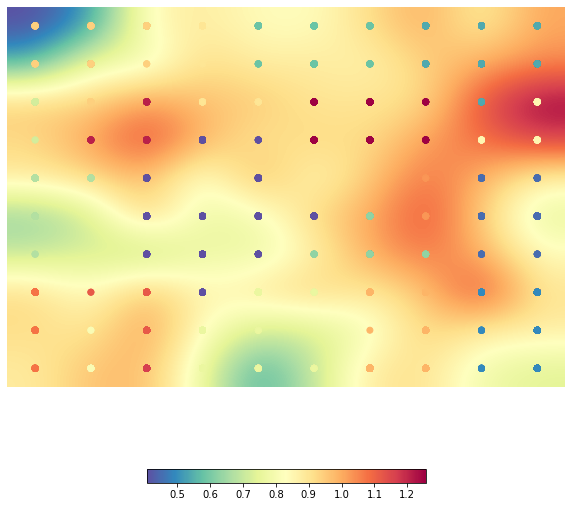

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 10))

### Σχόλια 
Από τον χάρτη αντιλαμβανόμαστε χοντρικά να χωρίζεται σε 5 περιοχές, από τις οποίες οι 3 είναι περισσότερο ξακάθαρες με μπλε, ένω οι άλλες δύο δεξιά περισσότερο πράσινες. Παρατηρούμε ακόμα ότι οι δεξία έχουν μεγαλύτερο διαχωρισμό, καθώς πριβάλλονται με πιο έντονο κόκκινο. Οι αριστερές, παρά το πιο έντονο μπλε, έχουν κοντινότερη απόσταση μεταξύ τους. Η κατηγορία που φαίνεται να είναι πιο ξακάθαρη είνια η πάνω αριστερά, κάτι που δείχνει ότι σημαντικός αριθμός ταινιών φέρουν συγκεκριμένη κατηγοριοποίηση. Γενικότερα καταλαβαίνουμε ότι οι περισσότερες ταινίες ανήκουν σε πολλά ήδη, κάτι που διαπιστώσαμε και από τα παραδείγματα του 1ου μέρους της άσκησης.

#### 20x20
##### k = 25

In [ ]:
from sklearn.cluster import KMeans

K = 25

algorithm = KMeans(n_clusters=K)
som20.cluster(algorithm=algorithm)

print("k=" + str(K) + ":\n")
print(som20.clusters)
#δεν το βάζουμε όλο για καλύτερη εμφάνιση 
print("Cluster sorted by increasing number of neurons:\nCluster index\nNumber of neurons")
neurons = np.zeros((2,K))
neur_tmp = [np.sum([som20.clusters == k]) for k in range(K)]
neurons[0,:] = np.argsort(neur_tmp)
neurons[1,:] = np.reshape(sorted(neur_tmp), (1,K))
print(neurons)

k=25:

[[ 2  2  2  2  5  5  5  5  5  5 15 15 15 15  1  1  1  1  1  1]
 [ 2  2  2  2 15  5  5  5  5  5 15 15 15 15  1  1  1  1  1  1]
 [ 2  2  2 17 15 15  5  5  5 15 15 15 15 15  1  1  1  1  1  1]
 [17 17  4  4  4  4 18 18 15 15 15 15 15 15  7  7  7  7  1  1]
 [17 17 17  4  4 18 18 18 14 14 14 14 15  7  7  7  7  7  1  1]
 [17 17 17  4  4 18 18 18  8 14 14 14 14  7  7  7  7  7  0  0]
 [17 17  4  4  4 18 18  8  8 14 14 14 13 13  7  7  7  0  0  0]
 [17 17  4  4  4 18  8  8  8 14 14 13 13 13 13 20 20 20  0  0]
 [17 17  4 24 24 24  8  8  8 23 23 23 13 13 21 20 20 20  0  0]
 [16 16 24 24 24 24  8  8  8 23 23 23 23 21 21 20 20  0  0  0]
 [16 16 24 24 24 24  8  8  8 23 23 23 21 21 21 21 21  0  0  0]
 [16 16 16 24 24 24  8  8  8 23 23 23 23 21 21 21 21 21  0  0]
 [16 16 16 16  3  3  3  1  1  9 23  9  9 21 21 19 19 19  0  0]
 [16 16 16  3  3  3  3  3  1  9  9  9  9  9 19 19 19 19 19 19]
 [16 16 10  3  3  3  3  3  6  6  9  9  9 12 19 19 19 19 19 19]
 [19 10 10 10  3  3  3 22 22  6  6  9  9 12 12 1

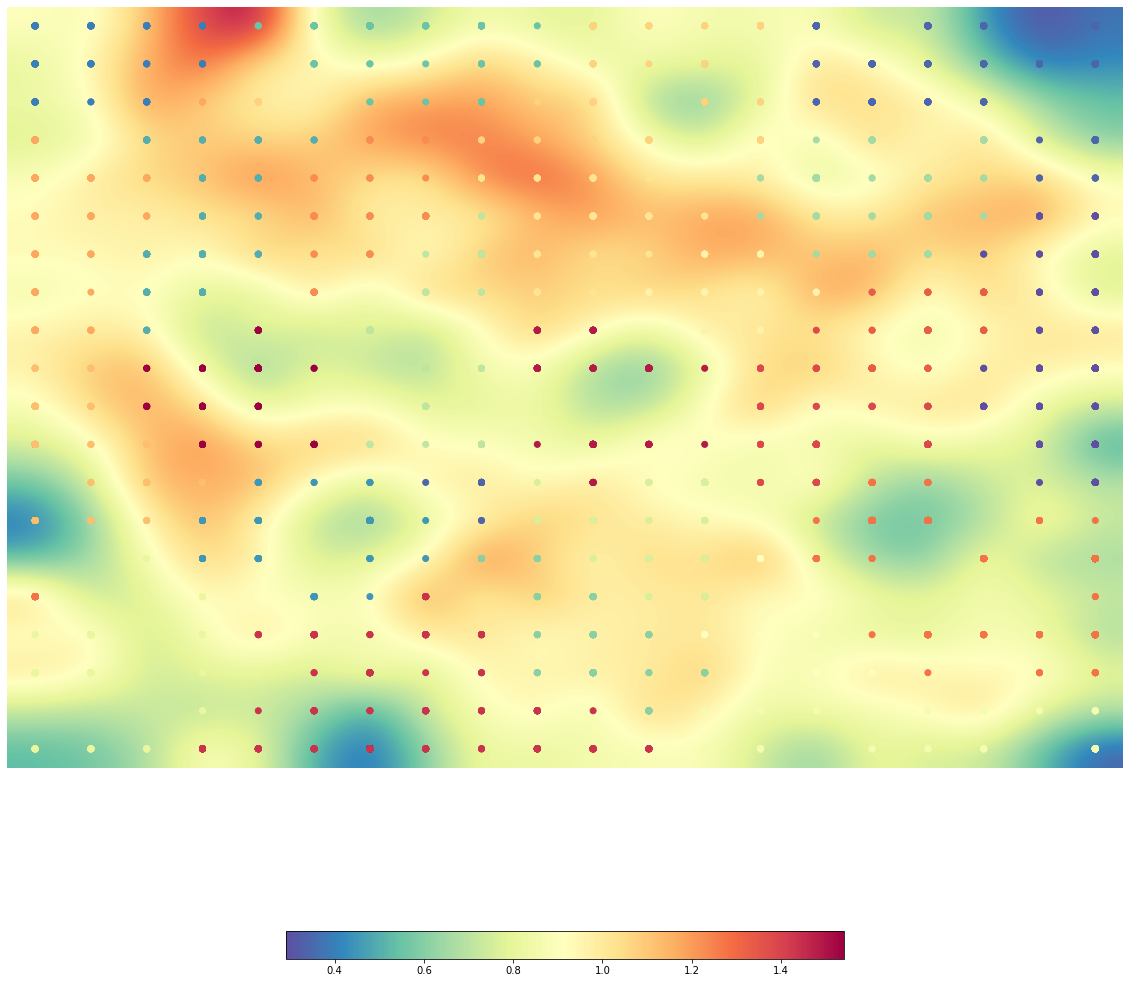

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som20.view_umatrix(bestmatches=True, colorbar=True, figsize=(20, 20))

### Σχόλια
Εδώ βλέπουμε αρκετα περισσότερες περιοχές, τόσο ξεκάθαρα διαχωρισμένες με μπλε χρώμα όσο και με πιο ελαφρύ πράσινο. Ο διαχωρισμος επίσης  φαίνεται να είναι λιγότερο έντονος σε σχέση με τον 10x10. Σίγουρα έχουμε χάρτη μεγαλύτερων διαστάσεων και γι αυτό βλέπουμε τις περιοχές να αυξάνονται. Παρ'όλα αυτα μεγαλύτερο με περισσότερες περιοχές δε σημαίνει απαραίτητα και καλύτερο αποτέλεσμα.


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def cluster_neurons_movies_report(cluster_id, som, size):
    # ταινίες που είναι στο cluster_id
    #dtype = np.int8
    a = np.sum(np.reshape([som.clusters == cluster_id], (1,size**2)), axis=0)
    a = np.reshape(a, (size,size)).transpose()
    where = np.where(a==1)
    # πιθανό bmu
    cluster_bmus = np.squeeze(np.dstack((where[0], where[1])))  
    ids = []
    for c_bmu in cluster_bmus:
        for i,bmu in enumerate(som.bmus):
            if np.array_equal(c_bmu, bmu):
                ids.append(i)    
    
    ids = np.array(ids)
    cluster_catbins = my_catbins[ids]
    '''
    Κατηγοριοποίησε τα ονόματα και τους δείκτες σε φθίνουσα διάταξη
    '''
    cat_indexes = np.argsort(np.sum(cluster_catbins, axis=0))[::-1]
    cat_sorted_names = [dict_idx_cat[i] for i in cat_indexes]

    # Βάλε τις συχνότηες σε φθίνουσα σειρά
    cat_freq = sorted(np.sum(cluster_catbins, axis=0))[::-1]

    # Stats
    cluster_stats_result = list(zip(cat_sorted_names, cat_freq))    
    print(cluster_stats_result[0:5])  

Χρησιμοποιούμε τα clustering που είδαμε προηγουμένως με k=25 για τον 10x10 και με k=20 για τον 20x20.

#### 10x10
##### k = 20

Κατηγοριοποιούμε τις ταινίες σε 20 κατηγορίες.

In [ ]:
%time cluster_neurons_movies_report(0, som, size=10)

[('"Action"', 141.0), ('"Adventure"', 98.0), ('"Documentary"', 96.0), ('"Comedy film"', 74.0), ('"Black-and-white"', 69.0)]
CPU times: user 385 ms, sys: 7.07 ms, total: 392 ms
Wall time: 388 ms


In [ ]:
%time cluster_neurons_movies_report(19, som, size=10)

[('"Thriller"', 240.0), ('"Horror"', 123.0), ('"Psychological thriller"', 71.0), ('"Mystery"', 65.0), ('"Crime Thriller"', 47.0)]
CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 191 ms


#### 20x20
##### k = 25

Εδώ έχουμε χωρίσει τις κατηγορίες σε 25.

In [ ]:
%time cluster_neurons_movies_report(0, som20, size=20)

[('"Horror"', 319.0), ('"Thriller"', 101.0), ('"Slasher"', 61.0), ('"Psychological thriller"', 41.0), ('"Cult"', 40.0)]
CPU times: user 506 ms, sys: 15.1 ms, total: 521 ms
Wall time: 509 ms


In [ ]:
%time cluster_neurons_movies_report(1, som20, size=20)

[('"Drama"', 753.0), ('"Black-and-white"', 73.0), ('"War film"', 50.0), ('"Family Film"', 45.0), ('"Musical"', 38.0)]
CPU times: user 619 ms, sys: 2.9 ms, total: 622 ms
Wall time: 628 ms


In [ ]:
%time cluster_neurons_movies_report(2, som20, size=20)

[('"Thriller"', 144.0), ('"Action"', 139.0), ('"Action/Adventure"', 110.0), ('"Crime Fiction"', 43.0), ('"Action Thrillers"', 34.0)]
CPU times: user 283 ms, sys: 2 ms, total: 285 ms
Wall time: 285 ms


In [ ]:
%time cluster_neurons_movies_report(3, som20, size=20)

[('"Comedy"', 139.0), ('"Drama"', 137.0), ('"Comedy-drama"', 56.0), ('"Indie"', 38.0), ('"Black comedy"', 23.0)]
CPU times: user 404 ms, sys: 0 ns, total: 404 ms
Wall time: 404 ms


In [ ]:
%time cluster_neurons_movies_report(4, som20, size=20)

[('"Crime Fiction"', 122.0), ('"Thriller"', 121.0), ('"Drama"', 102.0), ('"Crime Thriller"', 63.0), ('"Mystery"', 27.0)]
CPU times: user 383 ms, sys: 9.22 ms, total: 392 ms
Wall time: 386 ms


In [ ]:
%time cluster_neurons_movies_report(5, som20, size=20)

[('"World cinema"', 133.0), ('"Romance Film"', 131.0), ('"Drama"', 131.0), ('"Romantic drama"', 116.0), ('"Bollywood"', 51.0)]
CPU times: user 364 ms, sys: 3.11 ms, total: 367 ms
Wall time: 365 ms


In [ ]:
%time cluster_neurons_movies_report(6, som20, size=20)

[('"Comedy"', 115.0), ('"Family Film"', 103.0), ('"Adventure"', 38.0), ('"Children\'s/Family"', 26.0), ('"Drama"', 23.0)]
CPU times: user 301 ms, sys: 25 µs, total: 301 ms
Wall time: 304 ms


In [ ]:
%time cluster_neurons_movies_report(7, som20, size=20)

[('"Indie"', 146.0), ('"Drama"', 103.0), ('"Silent film"', 78.0), ('"Black-and-white"', 76.0), ('"Short Film"', 26.0)]
CPU times: user 440 ms, sys: 905 µs, total: 440 ms
Wall time: 445 ms


In [ ]:
%time cluster_neurons_movies_report(8, som20, size=20)

[('"Action"', 131.0), ('"Drama"', 130.0), ('"Action/Adventure"', 38.0), ('"Adventure"', 34.0), ('"Crime Fiction"', 30.0)]
CPU times: user 443 ms, sys: 0 ns, total: 443 ms
Wall time: 446 ms


In [ ]:
%time cluster_neurons_movies_report(9, som20, size=20)

[('"Adventure"', 113.0), ('"Family Film"', 57.0), ('"Fantasy"', 38.0), ('"Animation"', 32.0), ('"Science Fiction"', 25.0)]
CPU times: user 367 ms, sys: 16.6 ms, total: 383 ms
Wall time: 361 ms


In [ ]:
%time cluster_neurons_movies_report(10, som20, size=20)

[('"Romance Film"', 261.0), ('"Comedy"', 259.0), ('"Romantic comedy"', 184.0), ('"Drama"', 115.0), ('"Romantic drama"', 43.0)]
CPU times: user 516 ms, sys: 9.12 ms, total: 525 ms
Wall time: 521 ms


In [ ]:
%time cluster_neurons_movies_report(11, som20, size=20)

[('"Short Film"', 259.0), ('"Animation"', 154.0), ('"Family Film"', 77.0), ('"Comedy"', 52.0), ('"Comedy film"', 45.0)]
CPU times: user 401 ms, sys: 2.95 ms, total: 404 ms
Wall time: 406 ms


In [ ]:
%time cluster_neurons_movies_report(12, som20, size=20)

[('"Family Film"', 48.0), ('"Animation"', 42.0), ('"Children\'s/Family"', 25.0), ('"Fantasy"', 16.0), ('"Children\'s Fantasy"', 12.0)]
CPU times: user 259 ms, sys: 6.14 ms, total: 265 ms
Wall time: 262 ms


In [ ]:
%time cluster_neurons_movies_report(13, som20, size=20)

[('"Western"', 72.0), ('"Action/Adventure"', 51.0), ('"Action"', 29.0), ('"Drama"', 11.0), ('"Black-and-white"', 10.0)]
CPU times: user 206 ms, sys: 22 µs, total: 206 ms
Wall time: 213 ms


In [ ]:
%time cluster_neurons_movies_report(14, som20, size=20)

[('"Action/Adventure"', 100.0), ('"Action"', 83.0), ('"World cinema"', 56.0), ('"Comedy"', 51.0), ('"Martial Arts Film"', 42.0)]
CPU times: user 320 ms, sys: 2.01 ms, total: 322 ms
Wall time: 322 ms


In [ ]:
%time cluster_neurons_movies_report(15, som20, size=20)

[('"World cinema"', 231.0), ('"Drama"', 204.0), ('"Bollywood"', 55.0), ('"Musical"', 50.0), ('"Thriller"', 29.0)]
CPU times: user 570 ms, sys: 25 µs, total: 570 ms
Wall time: 571 ms


In [ ]:
%time cluster_neurons_movies_report(16, som20, size=20)

[('"Drama"', 230.0), ('"Romance Film"', 225.0), ('"Romantic drama"', 94.0), ('"Film adaptation"', 38.0), ('"Period piece"', 36.0)]
CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 481 ms


In [ ]:
%time cluster_neurons_movies_report(17, som20, size=20)

[('"Thriller"', 211.0), ('"Mystery"', 110.0), ('"Drama"', 90.0), ('"Crime Thriller"', 69.0), ('"Psychological thriller"', 67.0)]
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 371 ms


In [ ]:
%time cluster_neurons_movies_report(18, som20, size=20)

[('"Thriller"', 87.0), ('"Action"', 86.0), ('"Drama"', 84.0), ('"Action/Adventure"', 62.0), ('"Crime Fiction"', 48.0)]
CPU times: user 300 ms, sys: 19.3 ms, total: 319 ms
Wall time: 300 ms


In [ ]:
%time cluster_neurons_movies_report(19, som20, size=20)

[('"Documentary"', 95.0), ('"Comedy film"', 88.0), ('"Romance Film"', 56.0), ('"Silent film"', 50.0), ('"Musical"', 46.0)]
CPU times: user 727 ms, sys: 2.92 ms, total: 730 ms
Wall time: 731 ms


In [ ]:
%time cluster_neurons_movies_report(20, som20, size=20)

[('"Science Fiction"', 85.0), ('"Horror"', 63.0), ('"Creature Film"', 14.0), ('"Sci-Fi Horror"', 13.0), ('"Thriller"', 12.0)]
CPU times: user 401 ms, sys: 80.2 ms, total: 481 ms
Wall time: 385 ms


In [ ]:
%time cluster_neurons_movies_report(21, som20, size=20)

[('"Black-and-white"', 68.0), ('"Japanese Movies"', 45.0), ('"Silent film"', 15.0), ('"Science Fiction"', 13.0), ('"Crime Fiction"', 13.0)]
CPU times: user 402 ms, sys: 961 µs, total: 403 ms
Wall time: 404 ms


In [ ]:
%time cluster_neurons_movies_report(22, som20, size=20)

[('"Comedy"', 439.0), ('"Black-and-white"', 72.0), ('"Parody"', 50.0), ('"Short Film"', 49.0), ('"Indie"', 39.0)]
CPU times: user 682 ms, sys: 3.09 ms, total: 685 ms
Wall time: 681 ms


In [ ]:
%time cluster_neurons_movies_report(23, som20, size=20)

[('"Action"', 155.0), ('"Adventure"', 50.0), ('"Crime Fiction"', 24.0), ('"Comedy"', 22.0), ('"Science Fiction"', 17.0)]
CPU times: user 377 ms, sys: 977 µs, total: 378 ms
Wall time: 381 ms


In [ ]:
%time cluster_neurons_movies_report(24, som20, size=20)

[('"Action/Adventure"', 60.0), ('"World cinema"', 52.0), ('"Action"', 43.0), ('"Martial Arts Film"', 40.0), ('"Chinese Movies"', 29.0)]
CPU times: user 235 ms, sys: 0 ns, total: 235 ms
Wall time: 239 ms




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Καταλυκτικά παρατηρούμε ότι το cluster 19 έχει τους περισσότερους νευρώνες, έχει και τη μεγαλύτερη πυκνότητα πιθανότητας στο χώρο. Οι κατηγορίες που βρίσκονται είναι οι Κωμωδίες, οι Ρομαντικές Κωμωδίες, τα Μιούζικαλ και τα Ντοκιμαντερ που φαίνεται να ανήκουν σε μεγάλη οικογένεια κατηγοριών. Πολύ κοντά, σε αριθμό νευρώνων είναι και τα cluster 1 και 22, τα οποία εμπεριέχουν εκτός των άλλων τις κατηγορίες της Κωμωδίας, το Δράμα, της Οικογενειακής ταινίας. Γενικότερα οι μεγαλύτερες κατηγορίες των ταινίων είναι οι Comedy, Action και Drama.

Ακόμα παρατηρούμε ότι στις κόκκινες περιοχές, βρίσκονται κυρίως, από τα περισσότερο κόκινα στα λιγότερο, τα 2,5,18,14,24 και 7. Σε αυτά βλέπουμε ότι ανήκουν κύριες κατηγορίες οι οποίες όμως "μοιράζονται" άλλες κοντινές. Πιο συγκεκριμένα ταινίες κατηγοριας Action έχουν και την Action-Adventure ή Action-Thriller, ενώ ταινίες κατηγορίας Drama έχουν και την Romantic-Drama κτλ. Έτσι δικαιολογείται και η μεγαλύτερη απόσταση μεταξύ των cluster. 

Από την άλλη μεριά, εκείνα στις περισσότερο μπλε περιοχές, τα 1,11,22,16,10, βλέπουμε να ανήκουν αποκλειστικά σε μία από τις μεγάλες κατηγορίες, κυρίως Comedy και Drama και να μοιράζονται κατηγορίες μικρότερου μεγέθους όπως Black-and-White, Short Film, Family film. 

Τέλος η κατανομή τοπολογικά είναι αρκετά ικανοποιητική, αν λάβουμε υπόψην και τον περιορισμό στις δύο διαστάσεις.
